<a href="https://colab.research.google.com/github/edogriba/NAML-2024/blob/main/AutoEncoderForFraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection System using Autoencoders
*Project for Numerical Analysis for Machine Learning*

## Framing the problem

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import grad
from jax import random
from tqdm.notebook import tqdm
import time
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 88% 58.0M/66.0M [00:00<00:00, 107MB/s]
100% 66.0M/66.0M [00:00<00:00, 103MB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


It's easy to see that there are 30 features as columns of which 28 are labeled as Vn where n is number. This is due to the fact that banks or credit card provider in general cannot disclose any kind of sensistive nor personal information to third parties. Indeed these are simply the principal components of the original dataset. In this case since it is difficult to interpret those principal components, I start exploring the other columns relative to the features and the labels.

First let's try to plot the distribution of the amounts spent to see if the dataset has some problems (e. g. the value of the transactions could be cut off as we saw in the lab where we used the dataset of the California houses)

<Axes: xlabel='Amount', ylabel='Count'>

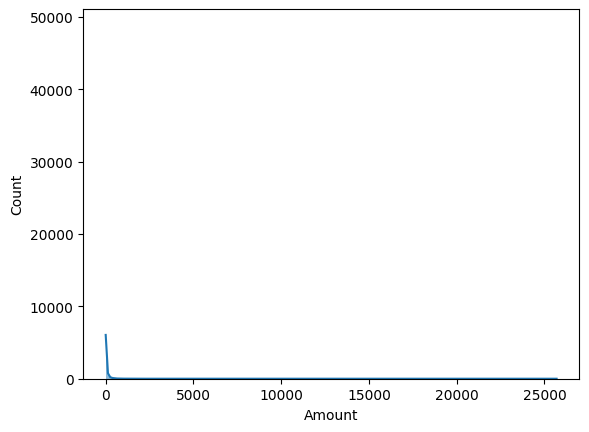

In [5]:
sns.histplot(data=df, kde=True, x="Amount")

I notice that the histogram is not nicely rendered and difficult to interpret since the transactions have a big difference in value, therefore let's plot them using a logarithmic scale


<Axes: xlabel='log_Amount', ylabel='Count'>

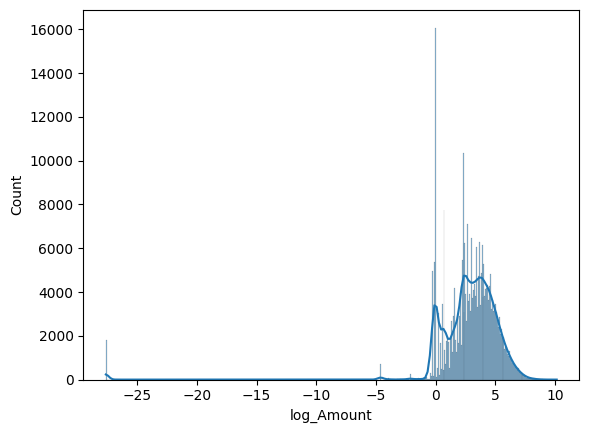

In [6]:
df["log_Amount"] = np.log(df["Amount"]+1e-12)

sns.histplot(data=df, kde=True, x="log_Amount")

Plotting the transactions with the natural logarithm scale and it's visible that most of them are included between ~$e^{-1}$ and ~$e^{-7}$ which makes sense as it means that most of the transactions are between ~0.36 € and ~1097 €. In particular apart of the spikes which are somehow normal in such datasets related to credit card transactions, the labels don't seem to suffer of any problem (e.g. a problem could be a concentration in one of the extreme of transaction amount meaning that probably one label was something like "more than 5000")

We can also get the same heatmap of the paper and see that there are not particular correlations between the features

<Axes: >

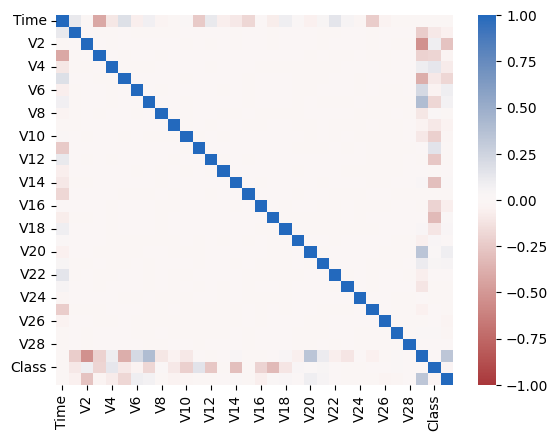

In [7]:
sns.heatmap(df.corr(), cmap="vlag_r", vmin=-1, vmax=1)

Now let's analyze the labels: the class is the target. It will have a value of  1 if the transaction is labelled as fraudulent (positive class) and 0 otherwise (negative class). Let's count the occurrences of the two.

In [8]:
value_counts = df['Class'].value_counts()

print(f"{(value_counts[1]/(value_counts[0]+value_counts[1])*100):.3f}%")

0.173%


The biggest problem about the dataset is that it is hugely unbalanced: on 284,807 transactions there are only 492 that are fraudulent: this amounts to only 0.17% of our dataset. This is a big problem indeed a naive classifier, which would always output 0 (flagging every transaction as non fradulent), would have an accuracy of 99.83% on this dataset, however it would be useless for the purpose since the whole point of a credit card fraud detection system is to find out the transactions that are fraudulent.
To tackle this matter, the paper uses as metrics not only the accuracy but also precision, recall and the F1 score

## Data Processing (Normalization, Shuffling and Splitting into Train and Test set)

In [9]:
y_true = df["Class"]
df.drop(columns=["log_Amount", "Class"], inplace=True)
mean = df.mean()
std = df.std()
df_normalized = (df - mean) / (std)

In [10]:
df_normalized.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,-1.149614e-16,-2.195443e-17,-1.516852e-17,-3.832046e-17,1.197515e-17,3.592544e-17,5.987573e-18,5.189230e-18,-8.981359e-19,5.488608e-18,...,-3.991715e-18,-3.193372e-18,6.386744e-18,-4.390887e-18,8.981359e-18,-3.512709e-17,1.319137e-17,2.220391e-18,-7.434569e-18,2.235360e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.996580e+00,-2.879850e+01,-4.403521e+01,-3.187168e+01,-4.013912e+00,-8.240795e+01,-1.963602e+01,-3.520933e+01,-6.130242e+01,-1.222799e+01,...,-7.069134e+01,-4.741898e+01,-1.506562e+01,-7.175434e+01,-4.683630e+00,-1.975030e+01,-5.401088e+00,-5.590650e+01,-4.674604e+01,-3.532288e-01
25%,-8.552105e-01,-4.698909e-01,-3.624701e-01,-5.872131e-01,-5.993777e-01,-5.010677e-01,-5.766811e-01,-4.478852e-01,-1.746801e-01,-5.853621e-01,...,-2.746329e-01,-3.109428e-01,-7.473463e-01,-2.591780e-01,-5.854666e-01,-6.083990e-01,-6.780705e-01,-1.755050e-01,-1.604437e-01,-3.308395e-01
50%,-2.131450e-01,9.245335e-03,3.965677e-02,1.186122e-01,-1.401721e-02,-3.936675e-02,-2.058043e-01,3.241718e-02,1.871979e-02,-4.681161e-02,...,-8.104691e-02,-4.009422e-02,9.345360e-03,-1.792417e-02,6.765666e-02,3.183234e-02,-1.081215e-01,3.325168e-03,3.406362e-02,-2.652710e-01
75%,9.372158e-01,6.716927e-01,4.867194e-01,6.774557e-01,5.250073e-01,4.433457e-01,2.991620e-01,4.611099e-01,2.740780e-01,5.435296e-01,...,1.725730e-01,2.537387e-01,7.283347e-01,2.364315e-01,7.257141e-01,6.727994e-01,4.996654e-01,2.255644e-01,2.371521e-01,-4.471699e-02
max,1.642055e+00,1.253349e+00,1.335773e+01,6.187982e+00,1.191872e+01,2.521409e+01,5.502005e+01,9.747807e+01,1.675150e+01,1.419492e+01,...,5.113455e+01,3.703465e+01,1.447302e+01,3.607661e+01,7.569671e+00,1.442529e+01,7.293962e+00,7.831926e+01,1.025432e+02,1.023621e+02


In [11]:
np.random.seed(0) # for reproducibility


df_normalized_np = df_normalized.to_numpy()
df_normalized_np = np.concatenate((df_normalized_np, y_true.to_numpy().reshape(-1, 1)), axis=1)
print(df_normalized_np)
np.random.shuffle(df_normalized_np)


fraction_test = 0.2

num_train = int(df_normalized_np.shape[0] * (1-fraction_test))
print("The training set is composed of", num_train)
print("The test set is composed of", df_normalized_np.shape[0] - num_train)

x_train = df_normalized_np[:num_train, :-1]

y_train = df_normalized_np[:num_train, -1:]

x_test = df_normalized_np[num_train:, :-1]

y_test = df_normalized_np[num_train:, -1:]

print("Train x", x_train.shape)
print("Train y", y_train.shape)
print("Test x", x_test.shape)
print("Test y", y_test.shape)

[[-1.99657952 -0.6942411  -0.04407485 ... -0.06378104  0.24496383
   0.        ]
 [-1.99657952  0.60849526  0.16117564 ...  0.04460744 -0.34247394
   0.        ]
 [-1.99655846 -0.69349925 -0.8115764  ... -0.18102051  1.16068389
   0.        ]
 ...
 [ 1.64197062  0.98002202 -0.1824334  ... -0.08046706 -0.08183916
   0.        ]
 [ 1.64197062 -0.12275518  0.32124978 ...  0.31668622 -0.31324798
   0.        ]
 [ 1.64205485 -0.27233046 -0.11489878 ...  0.04134991  0.51435441
   0.        ]]
The training set is composed of 227845
The test set is composed of 56962
Train x (227845, 30)
Train y (227845, 1)
Test x (56962, 30)
Test y (56962, 1)


In [12]:
np.unique(y_test, return_counts=True)

(array([0., 1.]), array([56861,   101]))

In [13]:
def compute_metrics(y, y_pred):
  TP = np.sum(np.logical_and(y_pred == 1., y == 1.))
  TN = np.sum(np.logical_and(y_pred == 0., y == 0.))
  FP = np.sum(np.logical_and(y_pred == 1., y == 0.))
  FN = np.sum(np.logical_and(y_pred == 0., y == 1.))

  eps = 1e-10
  accuracy = ((TN + TP) / len(y)) * 100 # Accuracy
  recall = (TP / (FN + TP)) * 100 # Recall or sensitivity
  precision = (TP / (FP + TP)) * 100 # Precision
  MCC = (TP * TN - FP * FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN) +eps) # MCC with eps for stability
  if MCC > 1:
    MCC = 1
  elif MCC < -1:
    MCC = -1
  F1 = (2 * precision * recall) / (precision + recall)

  print(f"Accuracy: {accuracy:.2f}%")
  print(f"Recall: {recall:.2f}%")
  print(f"Precision: {precision:.2f}%")
  print(f"F1: {F1:.2f}%")
  print(f"MCC: {MCC:.2f}")
  print(f"TP: {TP}")
  print(f"TN: {TN}")
  print(f"FP: {FP}")
  print(f"FN: {FN}")



def metrics_from_confusion_matrix(matrix):
  TP = matrix[1, 1]
  TN = matrix[0, 0]
  FP = matrix[0, 1]
  FN = matrix[1, 0]
  eps = 1e-10
  accuracy = ((TN + TP) / (TP+TN+FP+FN)) * 100 # Accuracy
  recall = (TP / (FN + TP)) * 100 # Recall or sensitivity
  precision = (TP / (FP + TP)) * 100 # Precision
  MCC = (TP * TN - FP * FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN) +eps) # MCC with eps for stability
  if MCC > 1:
    MCC = 1
  elif MCC < -1:
    MCC = -1

  print(f"Accuracy: {accuracy:.2f}%")
  print(f"Recall: {recall:.2f}%")
  print(f"Precision: {precision:.2f}%")
  print(f"MCC: {MCC:.2f}")


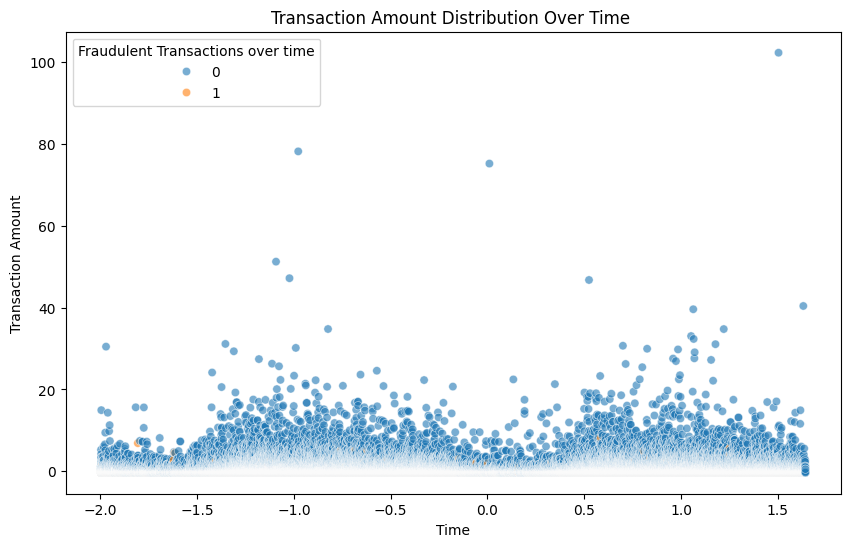

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_normalized["Time"], y=df_normalized["Amount"], hue=y_true, alpha=0.6)
plt.xlabel("Time")
plt.ylabel("Transaction Amount")
plt.title("Transaction Amount Distribution Over Time ")
plt.legend(title="Fraudulent Transactions over time")
plt.show()

## ANN

In [15]:
def initialize_params_ANN(layers_size):
  np.random.seed(0)
  params = list()
  for i in range(len(layers_size)-1):
    std = np.sqrt(2/(layers_size[i+1]+ layers_size[i]))
    w = np.random.randn(layers_size[i+1], layers_size[i]) * std
    b = np.zeros((layers_size[i+1], 1))
    params.append(w)
    params.append(b)
  return params

In [16]:
params = initialize_params_ANN([30, 10, 5, 1])

act_fn = jnp.tanh

def ANN(x, params):

  layer = x.T
  num_layers = len(params) // 2 + 1
  weights = params[::2]
  biases = params[1::2]
  for i in range(num_layers-1):
    layer = jnp.dot(weights[i], layer) + biases[i] # jnp.dot() replaceable by @
    if i < num_layers - 2: # on the last layer the activation function forces the output to be in the range we want
      layer = act_fn(layer)
    else:
      layer = 1 / (1 + jnp.exp(-layer))
  return layer.T


In [17]:
def loss_mse_ANN(x, y, params):
  return jnp.mean((y - ANN(x, params))**2)

loss_jit = jax.jit(loss_mse_ANN)
grad_jit = jax.jit(jax.grad(loss_jit, argnums= 2))

In [18]:
def loss_X_ent_ANN(x, y, params):
    y_pred = ANN(x, params)
    eps = 1e-6
    return -jnp.mean(y * jnp.log(y_pred + eps) + (1-y) * jnp.log(1 - y_pred + eps))

### Vanilla Gradient Descent Training

It works well but it is really slow

  0%|          | 0/1500 [00:00<?, ?it/s]

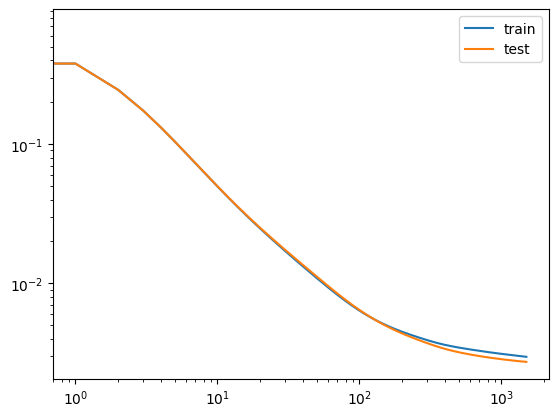

In [19]:
# Hyperparameters
layers_size = [30, 20, 10, 1]
num_epochs = 1500
learning_rate = 0.8

params = initialize_params_ANN(layers_size)
grad = jax.grad(loss_X_ent_ANN, argnums=2)

# Just in time
loss_jit = jax.jit(loss_X_ent_ANN)
grad_jit = jax.jit(grad)

n_samples = x_train.shape[0]

history_loss_train = []
history_loss_test = []


history_loss_train.append(loss_X_ent_ANN(x_train, y_train, params))
history_loss_test.append(loss_X_ent_ANN(x_test, y_test, params))

for epoch in tqdm(range(num_epochs)):
  grad_vals = grad_jit(x_train, y_train, params)
  for i in range(len(params)):
    params[i] = params[i] - learning_rate * grad_vals[i]

  history_loss_train.append(loss_X_ent_ANN(x_train, y_train, params))
  history_loss_test.append(loss_X_ent_ANN(x_test, y_test, params))

plt.loglog(history_loss_train, label="train")
plt.loglog(history_loss_test, label="test")
plt.legend()


In [20]:
ANN_pred_test = ANN(x_test, params)
y_pred_test = np.where(ANN_pred_test >= 0.5, 1., 0.)
compute_metrics(y_test, y_pred_test)


Accuracy: 99.95%
Recall: 79.21%
Precision: 88.89%
F1: 83.77%
MCC: 0.84
TP: 80
TN: 56851
FP: 10
FN: 21


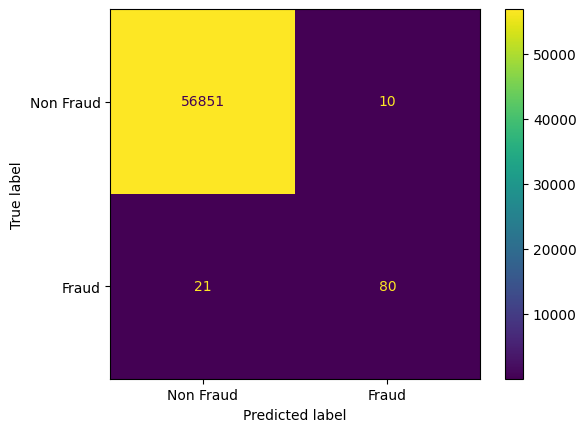

In [21]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test), display_labels=["Non Fraud", "Fraud"]).plot()

### RMSProp Training

It works well but it's much faster

  0%|          | 0/500 [00:00<?, ?it/s]

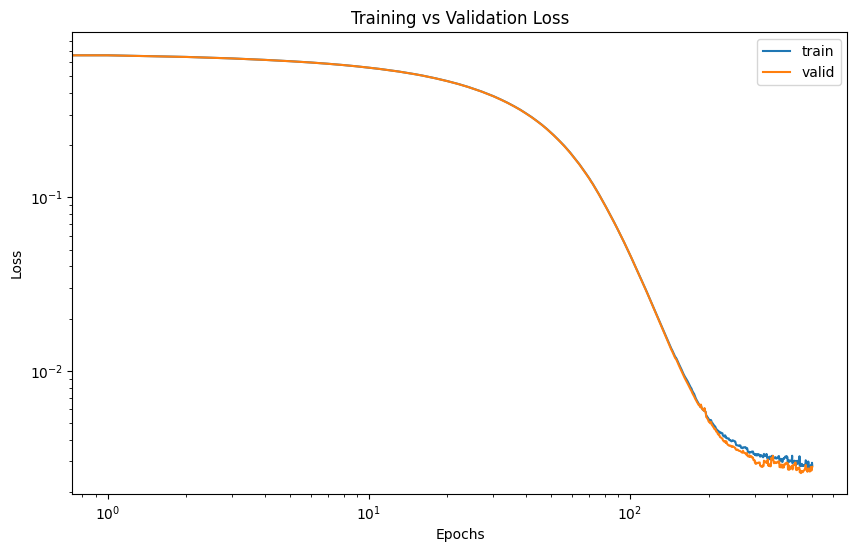

Final Train Loss: 0.0028517472
Final Validation Loss: 0.0027946574


In [22]:
# Hyperparameters
layers_size = [30, 20, 10, 1]
# Training options
num_epochs = 500
batch_size = 1000
learning_rate = 2e-3
decay_rate = 0.9
delta = 1e-6  # Increased for stability

#################################################
# Initialize params and jit objects
params = initialize_params_ANN(layers_size)
grad = jax.grad(loss_X_ent_ANN, argnums=2)
grad_jit = jax.jit(grad)
cross_entropy_jit = jax.jit(loss_X_ent_ANN)

#################################################

history_train_Xen = list()
history_valid_Xen = list()

n_train = x_train.shape[0]
cumulated_sqr_grad = [0.0 for _ in range(len(params))]

for epoch in tqdm(range(num_epochs)):
    idxs = np.random.choice(n_train, batch_size, replace=False)  # Use `replace=False` for diversity in batches
    grad_val = grad_jit(x_train[idxs, :], y_train[idxs, :], params)  # FIXED indexing

    for i in range(len(params)):
        # Accumulate squared gradients
        cumulated_sqr_grad[i] = (decay_rate * cumulated_sqr_grad[i] +
                                 (1 - decay_rate) * grad_val[i] * grad_val[i])

        # Update parameters using adaptive learning rate
        params[i] -= grad_val[i] * learning_rate * (1 / (delta + jnp.sqrt(cumulated_sqr_grad[i])))

    # Compute loss once per epoch, not per parameter update
    history_train_Xen.append(cross_entropy_jit(x_train, y_train, params))
    history_valid_Xen.append(cross_entropy_jit(x_test, y_test, params))

# Plot loss curves (fixed variable names)
plt.figure(figsize=(10, 6))
plt.loglog(history_train_Xen, label="train")
plt.loglog(history_valid_Xen, label="valid")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.show()

print("Final Train Loss:", history_train_Xen[-1])
print("Final Validation Loss:", history_valid_Xen[-1])

In [23]:
ANN_pred_test = ANN(x_test, params)
y_pred_test = np.where(ANN_pred_test >= 0.5, 1., 0.)
compute_metrics(y_test, y_pred_test)

Accuracy: 99.94%
Recall: 72.28%
Precision: 90.12%
F1: 80.22%
MCC: 0.81
TP: 73
TN: 56853
FP: 8
FN: 28


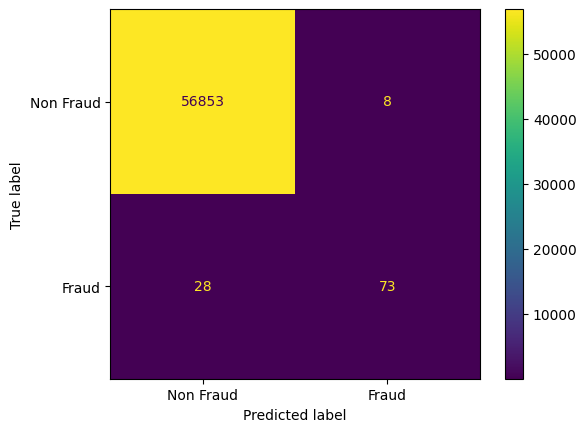

In [24]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test), display_labels=["Non Fraud", "Fraud"]).plot()

## Autoencoder

### Autoencoder trained on fraudulent transactions

As told in the paper we train the autoencoder only on the fraudulent transactions so that he learns how to represent them well

In [25]:
x_train_ae = x_train[y_train[:, 0] == 1]

# Normalize x_train_ae
mean = x_train_ae.mean(axis=0)
std = x_train_ae.std(axis=0)
x_train_ae = (x_train_ae - mean) / std

print(x_train_ae.shape)

(391, 30)


In [26]:
def initialize_params(layers_size):
  np.random.seed(0)
  params = list()
  for i in range(len(layers_size)-1):
    std = np.sqrt(2/(layers_size[i+1]+ layers_size[i]))
    w = np.random.randn(layers_size[i+1], layers_size[i]) * std
    b = np.zeros((layers_size[i+1], 1))
    params.append(w)
    params.append(b)
  return params

def sigm(z):
    return (jnp.tanh(2*z)+1)/2

params_enc = initialize_params([30, 15])

act_fn = jnp.tanh

def encoder(x, params):

  layer = x.T
  num_layers = len(params) // 2 + 1
  weights = params[::2]
  biases = params[1::2]
  for i in range(num_layers-1):
    layer = jnp.dot(weights[i], layer) + biases[i]
    if i < num_layers - 2: # on the last layer the activation function forces the output to be in the range we want
      layer = act_fn(layer)
    else:
      layer = sigm(layer)
  return layer.T

params_dec = initialize_params([15, 30])

def decoder(x, params):

  layer = x.T
  num_layers = len(params) // 2 + 1
  weights = params[::2]
  biases = params[1::2]
  for i in range(num_layers-1):
    layer = jnp.dot(weights[i], layer) + biases[i]
    if i < num_layers - 2: # on the last layer the activation function forces the output to be in the range we want
      layer = act_fn(layer)
    else:
      layer = sigm(layer)
  return layer.T

def autoencoder(x, params_enc, params_dec):
    encoded = encoder(x, params_enc)
    reconstructed = decoder(encoded, params_dec)
    return reconstructed

# Loss function
def loss_mse_ae(x, params_enc, params_dec):
    x_reconstructed = autoencoder(x, params_enc, params_dec)
    return jnp.mean((x - x_reconstructed) ** 2)


391


  0%|          | 0/3000 [00:00<?, ?it/s]

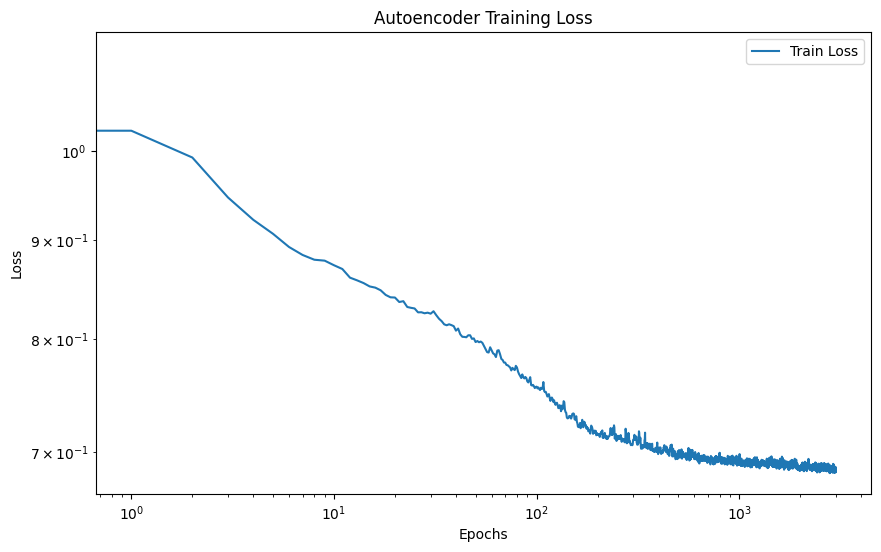

Final Train Loss: 0.6867936


In [27]:
num_epochs = 3000
batch_size = 5
learning_rate = 1.75e-2
decay_rate = 0.9
delta = 1e-6
layers_size = [30, 15, 30]

# Initialize encoder and decoder parameters

# Just 2 layers to avoid overfitting
params_enc = initialize_params([30, 15])
params_dec = initialize_params([15, 30])

# Compute gradients
grad = jax.grad(loss_mse_ae, argnums=(1, 2))  # Compute gradients w.r.t. encoder and decoder
grad_jit = jax.jit(grad)  # JIT compilation for faster execution
mse_ae_jit = jax.jit(loss_mse_ae)

# Training loop
history_train = []
n_train = x_train_ae.shape[0]
print(n_train)
cumulated_sqr_grad_enc = [0.0 for _ in range(len(params_enc))]
cumulated_sqr_grad_dec = [0.0 for _ in range(len(params_dec))]

for epoch in tqdm(range(num_epochs)):
    idxs = np.random.choice(n_train, batch_size, replace=False)

    # Compute gradients
    grad_enc, grad_dec = grad_jit(x_train_ae[idxs, :], params_enc, params_dec)

    # Update encoder parameters
    for i in range(len(params_enc)):
        cumulated_sqr_grad_enc[i] = (decay_rate * cumulated_sqr_grad_enc[i] + (1 - decay_rate) * grad_enc[i] ** 2)
        params_enc[i] -= grad_enc[i] * learning_rate * (1 / (delta + jnp.sqrt(cumulated_sqr_grad_enc[i])))

    # Update decoder parameters
    for i in range(len(params_dec)):
        cumulated_sqr_grad_dec[i] = (decay_rate * cumulated_sqr_grad_dec[i] + (1 - decay_rate) * grad_dec[i] ** 2)
        params_dec[i] -= grad_dec[i] * learning_rate * (1 / (delta + jnp.sqrt(cumulated_sqr_grad_dec[i])))

    # Compute loss
    history_train.append(mse_ae_jit(x_train_ae, params_enc, params_dec))

# Plot training loss
plt.figure(figsize=(10, 6))
plt.loglog(history_train, label="Train Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Autoencoder Training Loss")
plt.show()

print("Final Train Loss:", history_train[-1])

In [28]:
encoded_train = encoder(x_train, params_enc)
encoded_test = encoder(x_test, params_enc)

### Logistic Regression from Sklearn library

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

model = LogisticRegression()
model.fit(encoded_train, y_train)
y_pred = model.predict(encoded_test)
# Print Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print Formatted Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix:
[[56853     8]
 [   48    53]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56861
         1.0       0.87      0.52      0.65       101

    accuracy                           1.00     56962
   macro avg       0.93      0.76      0.83     56962
weighted avg       1.00      1.00      1.00     56962



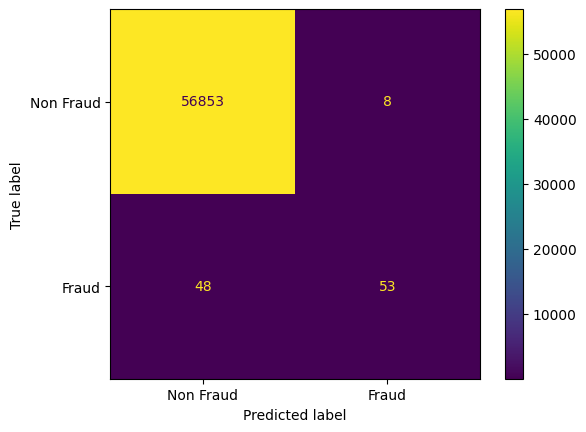

In [30]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Non Fraud", "Fraud"]).plot()

### Random Forest from Sklearn library

In [31]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(encoded_train, y_train)
y_pred = model.predict(encoded_test)
confusion_matrix(y_test, y_pred)

# Print Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print Formatted Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Confusion Matrix:
[[56857     4]
 [   23    78]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56861
         1.0       0.95      0.77      0.85       101

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



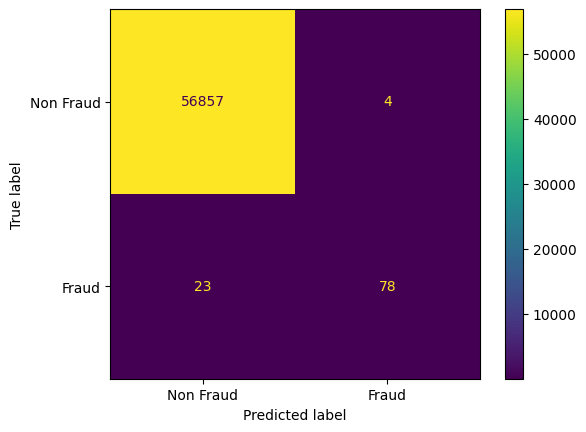

In [32]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Non Fraud", "Fraud"]).plot()

### Support Vector Regression from Sklearn library

In [33]:
from sklearn.svm import SVC

model = SVC()
model.fit(encoded_train, y_train)
y_pred = model.predict(encoded_test)
confusion_matrix(y_test, y_pred)
# Print Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print Formatted Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix:
[[56852     9]
 [   33    68]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56861
         1.0       0.88      0.67      0.76       101

    accuracy                           1.00     56962
   macro avg       0.94      0.84      0.88     56962
weighted avg       1.00      1.00      1.00     56962



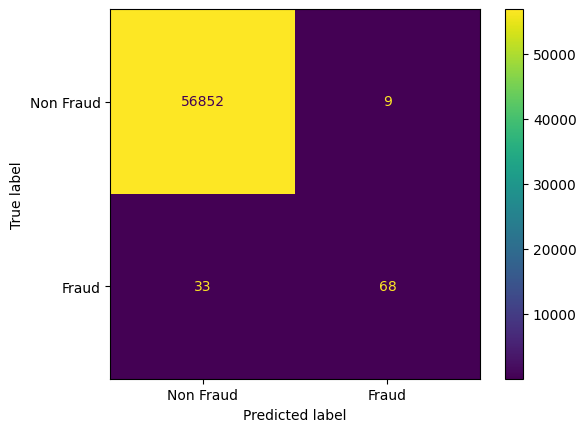

In [34]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Non Fraud", "Fraud"]).plot()

### Logistic Regression by me

In [35]:
def initialize_w_b(seed=0):
  np.random.seed(seed)
  w = np.random.randn(15, 1) * np.sqrt(2 / 15)
  b = jnp.array([0.0])

  print(w.shape)
  print(b.shape)

  params = list()
  params.append(w)
  params.append(b)

  return params


In [36]:
def sigm(z):
    return (jnp.tanh(2*z)+1)/2

def loss_X_ent(x, y, params):
    y_pred = sigm(x @ params[0] + params[1])
    eps = 1e-6
    return -jnp.mean( y * jnp.log(y_pred + eps) + (1-y) * jnp.log(1 - y_pred + eps))

def mse_loss(x, y, params):
    y_pred = x @ params[0] + params[1]
    return jnp.mean((y - y_pred)**2)

In [37]:
def LR_BGD(x_train, y_train, x_test, y_test, num_epochs=100, learning_rate_max=3.3e-1, learning_rate_min = 1e-2, learning_rate_decay = 200, batch_size = 1000):


  params = initialize_w_b()
  num_epochs = int(num_epochs)


  ########################################

  grad = jax.jit(jax.grad(loss_X_ent, argnums=2))
  loss_jit = jax.jit(loss_X_ent)

  n_samples = x_train.shape[0]

  history_train = list()
  history_test = list()
  history_train.append(loss_jit(x_train, y_train, params))
  history_test.append(loss_jit(x_test, y_test, params))


  for epoch in tqdm(range(num_epochs)):
      learning_rate = max(
          learning_rate_min, learning_rate_max * (1 - epoch / learning_rate_decay)
      )

      perm = np.random.permutation(n_samples)
      for i in range(0, n_samples, batch_size):
          batch_idx = perm[i : i + batch_size]
          x_batch = x_train[batch_idx]
          y_batch = y_train[batch_idx]
          grads = grad(x_batch, y_batch, params)

          for i in range(len(params)):
              params[i] -= learning_rate * grads[i]
      #print(loss_jit(x_train, y_train, params))
      #print(loss_jit(x_test, y_test, params))
      history_train.append(loss_jit(x_train, y_train, params))
      history_test.append(loss_jit(x_test, y_test, params))
  show_results(history_train, history_test)

  return params

def show_results(history_train, history_test):

  print("loss train: %1.3e" % history_train[-1])
  print("loss test: %1.3e" % history_test[-1])

  fig, axs = plt.subplots(1, figsize=(16, 8))
  axs.loglog(history_train, label="train")
  axs.loglog(history_test, label="test")
  plt.legend()

(15, 1)
(1,)


  0%|          | 0/100 [00:00<?, ?it/s]

loss train: 5.094e-03
loss test: 4.332e-03


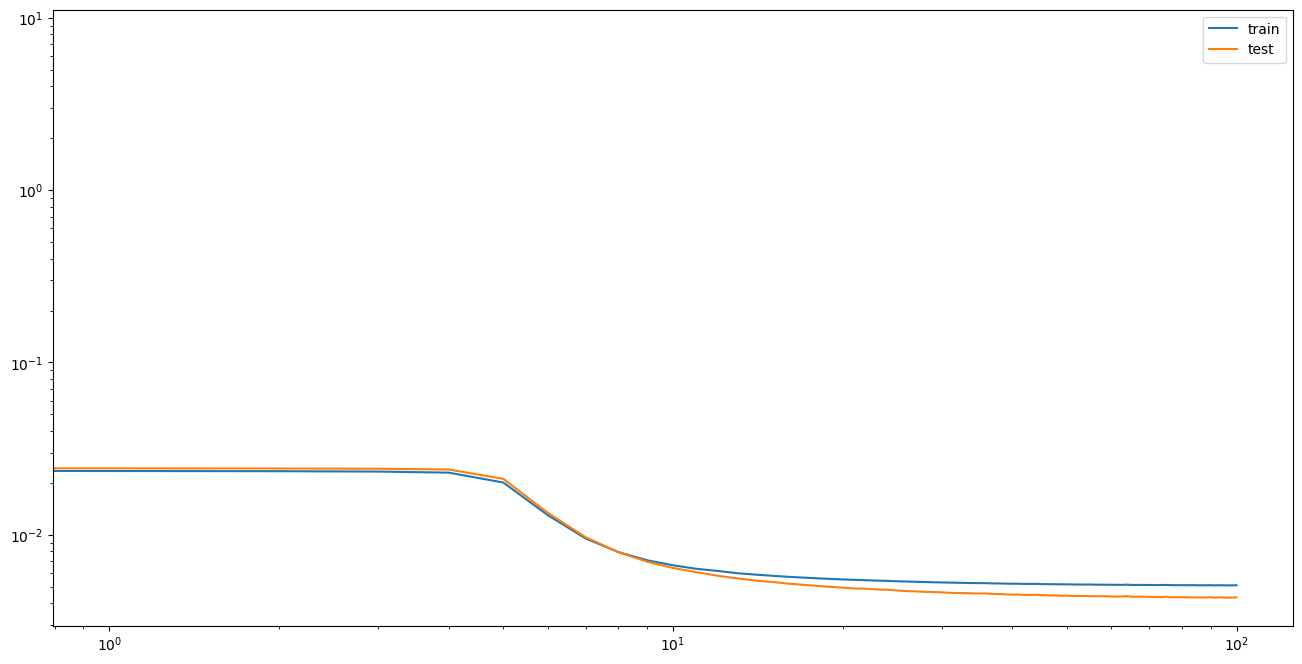

In [38]:
params = LR_BGD(encoded_train, y_train, encoded_test, y_test)

In [39]:
compute_metrics(y_test, np.where(sigm(encoded_test @ params[0] + params[1]) >= 0.5, 1., 0.))

Accuracy: 99.90%
Recall: 49.50%
Precision: 86.21%
F1: 62.89%
MCC: 0.65
TP: 50
TN: 56853
FP: 8
FN: 51


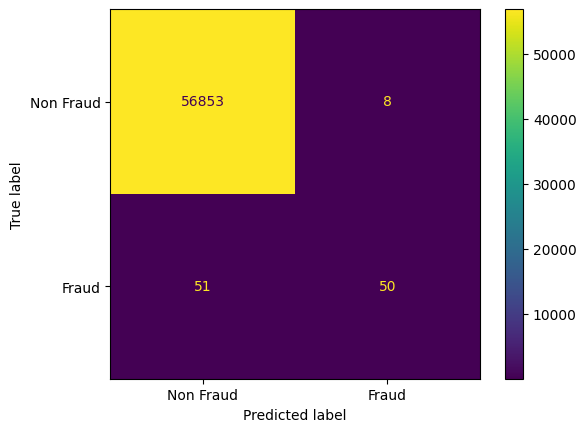

In [40]:
ConfusionMatrixDisplay(confusion_matrix(y_test, np.where(sigm(encoded_test @ params[0] + params[1]) >= 0.5, 1., 0.)), display_labels=["Non Fraud", "Fraud"]).plot()

### Extra: Autoencoder trained on non fraudulent transactions

In [41]:
x_train_ae = x_train[y_train[:, 0] == 0] # Training set composed of only fraudulent transactions

# Normalize x_train_ae
mean = x_train_ae.mean(axis=0)
std = x_train_ae.std(axis=0)
x_train_ae = (x_train_ae - mean) / std


  0%|          | 0/250 [00:00<?, ?it/s]

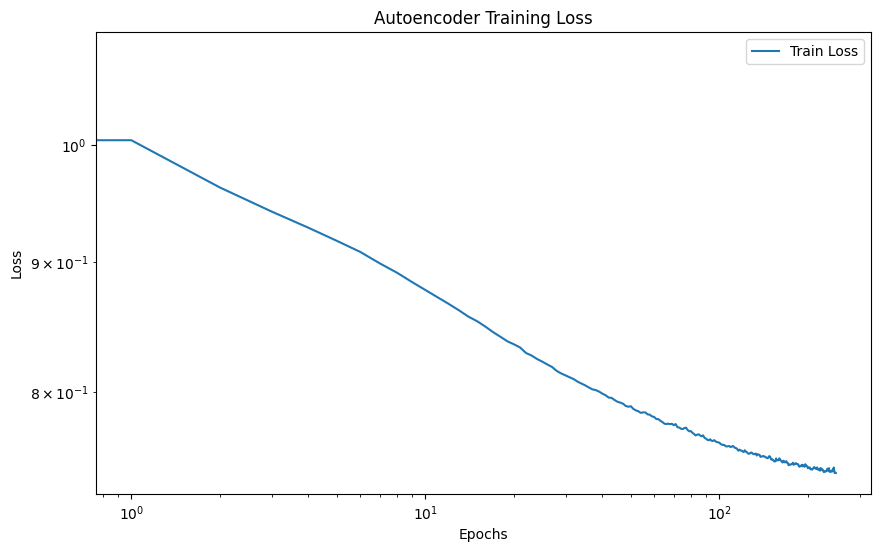

Final Train Loss: 0.7438449


In [42]:
num_epochs = 250
batch_size = 1000
learning_rate = 1.75e-2
decay_rate = 0.9
delta = 1e-6
layers_size = [30, 15, 30]

# Initialize encoder and decoder parameters
params_enc = initialize_params([30, 15])
params_dec = initialize_params([15, 30])

# Compute gradients
grad = jax.grad(loss_mse_ae, argnums=(1, 2))  # Compute gradients w.r.t. encoder and decoder
grad_jit = jax.jit(grad)
mse_ae_jit = jax.jit(loss_mse_ae)

# Training loop
history_train = []
n_train = x_train_ae.shape[0]
cumulated_sqr_grad_enc = [0.0 for _ in range(len(params_enc))]
cumulated_sqr_grad_dec = [0.0 for _ in range(len(params_dec))]

for epoch in tqdm(range(num_epochs)):
    idxs = np.random.choice(n_train, batch_size, replace=False)

    # Compute gradients
    grad_enc, grad_dec = grad_jit(x_train_ae[idxs, :], params_enc, params_dec)

    # Update encoder parameters
    for i in range(len(params_enc)):
        cumulated_sqr_grad_enc[i] = (decay_rate * cumulated_sqr_grad_enc[i] + (1 - decay_rate) * grad_enc[i] ** 2)
        params_enc[i] -= grad_enc[i] * learning_rate * (1 / (delta + jnp.sqrt(cumulated_sqr_grad_enc[i])))

    # Update decoder parameters
    for i in range(len(params_dec)):
        cumulated_sqr_grad_dec[i] = (decay_rate * cumulated_sqr_grad_dec[i] + (1 - decay_rate) * grad_dec[i] ** 2)
        params_dec[i] -= grad_dec[i] * learning_rate * (1 / (delta + jnp.sqrt(cumulated_sqr_grad_dec[i])))

    # Compute loss
    history_train.append(mse_ae_jit(x_train_ae, params_enc, params_dec))

# Plot training loss
plt.figure(figsize=(10, 6))
plt.loglog(history_train, label="Train Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Autoencoder Training Loss")
plt.show()

print("Final Train Loss:", history_train[-1])

In [43]:
encoded_train = encoder(x_train, params_enc)
encoded_test = encoder(x_test, params_enc)

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

model = LogisticRegression()
model.fit(encoded_train, y_train)
y_pred = model.predict(encoded_test)
# Print Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



# Print Formatted Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix:
[[56847    14]
 [   31    70]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56861
         1.0       0.83      0.69      0.76       101

    accuracy                           1.00     56962
   macro avg       0.92      0.85      0.88     56962
weighted avg       1.00      1.00      1.00     56962



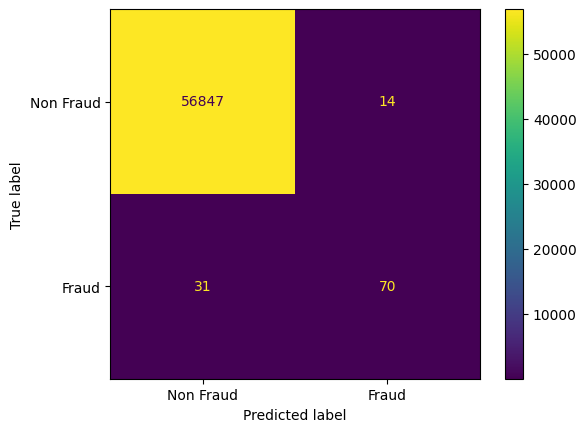

In [45]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Non Fraud", "Fraud"]).plot()

In [46]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(encoded_train, y_train)
y_pred = model.predict(encoded_test)
confusion_matrix(y_test, y_pred)

# Print Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print Formatted Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Confusion Matrix:
[[56856     5]
 [   26    75]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56861
         1.0       0.94      0.74      0.83       101

    accuracy                           1.00     56962
   macro avg       0.97      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962



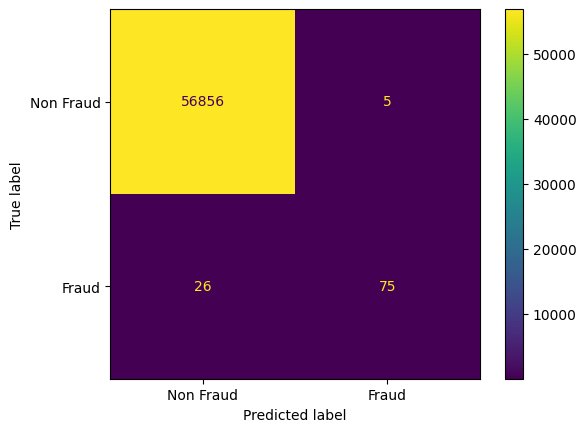

In [47]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Non Fraud", "Fraud"]).plot()

In [48]:
from sklearn.svm import SVC

model = SVC()
model.fit(encoded_train, y_train)
y_pred = model.predict(encoded_test)
confusion_matrix(y_test, y_pred)
# Print Confusion Matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix:
[[56847    14]
 [   21    80]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56861
         1.0       0.85      0.79      0.82       101

    accuracy                           1.00     56962
   macro avg       0.93      0.90      0.91     56962
weighted avg       1.00      1.00      1.00     56962



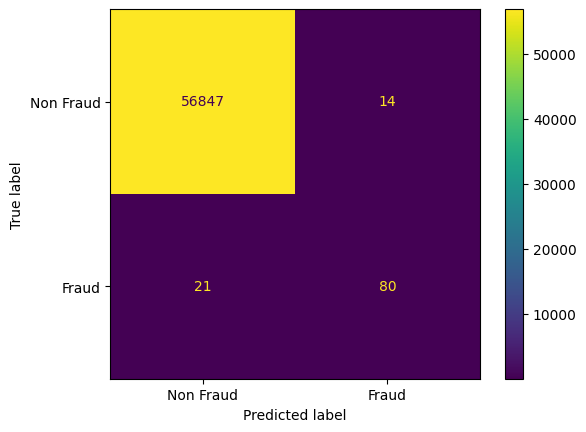

In [49]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Non Fraud", "Fraud"]).plot()